In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
import pickle as pkl
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import os

# define the path
data_path = "./datasets/anomaly_prediction/"
result_path = "./results/"
# Add the path to the OS environment PATH
os.environ["PATH"] += os.pathsep + data_path

In [26]:
device="cuda:0" if torch.cuda.is_available() else "cpu"

In [27]:
# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, input_length=50, output_length=50, device="cpu"):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.input_length = input_length
        self.output_length = output_length

    def __len__(self):
        return len(self.X) - self.input_length - self.output_length

    def __getitem__(self, idx):
        x = self.X[idx:idx + self.input_length]
        y = self.y[idx + self.input_length:idx + self.input_length + self.output_length]
        return x, y


In [28]:
# Define the Model
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleLinearModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input for the linear layers
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        #x = self.sigmoid(x)
        return x.view(x.size(0), -1)  # Reshape the output back to (batch_size, output_length)


In [30]:
class CumulLoss(nn.Module):
    def __init__(self, reduction='none'):
        super(CumulLoss, self).__init__()
        self.mae_loss = nn.L1Loss(reduction=reduction)

    def forward(self, outputs, labels):
        # Compute the cumulative sum along the sequence dimension (dim=1)
        cum_outputs = torch.cumsum(outputs, dim=1)
        cum_labels = torch.cumsum(labels, dim=1)

        # Compute the MAE loss between the cumulative sums of outputs and labels
        loss = self.mae_loss(cum_outputs, cum_labels)
        return loss

# Example usage
# Assuming `outputs` is the model's output tensor and `labels` is the ground truth tensor
outputs = torch.tensor([[1, 1, 1, 0, 0, 1]], dtype=torch.float32)  # Example output (batch_size, sequence_length)
labels = torch.tensor([[0, 0, 0, 1, 0, 1]], dtype=torch.float32)  # Example labels (batch_size, sequence_length)

criterion = CumulLoss(reduction='none')
loss = criterion(outputs, labels,)
print(loss)


tensor([[1., 2., 3., 2., 2., 2.]])


In [31]:
import pickle as pkl
f_name_list = []
for i in range(1,11):
  f_name = data_path + f"synthetical_{i}.pkl"
  f_name_list.append(f_name)


In [32]:
f_name_list[0][-17:]

'synthetical_1.pkl'

In [33]:
"""
with open(path + "result_dnn.pkl", "wb") as f:
  pkl.dump({}, f)
"""
with open(result_path + "result_dnn.pkl", "wb") as f:
  pkl.dump({}, f)


In [34]:
torch.manual_seed(2021)

def experiments(X, y , dataset, model, iterations=2, num_epochs=100, patience=10):
  f1_existence_list = []
  average_density_sum_list = []
  average_lead_time_list = []
  average_dice_score_list = []
  average_cumloss_scores_list = []

  train_loss_list = []
  val_loss_list = []
  test_loss_list = []

  # Use StratifiedKFold for 5-fold cross-validation
  #skf = StratifiedKFold(n_splits=5)
  skf = KFold(n_splits=5)

  input_length, output_length = dataset.input_length, dataset.input_length

  # Iterate through each fold
  for fold, (train_idx, test_idx) in enumerate(skf.split(X[input_length+output_length:, :], y[input_length+output_length:])):
      print(f'Fold {fold+1}')
      print(f'train_idx {train_idx}, test_idx {test_idx}, ')
      if fold != 4:
        continue
      
  for i in range(iterations):
      # Create train and test subsets
      train_dataset = Subset(dataset, train_idx)
      test_dataset = Subset(dataset, test_idx)

      # Calculate the validation set size
      val_size = len(train_dataset) // 8
      train_size = len(train_dataset) - val_size

      # Split train dataset into train and validation sets
      #train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
      train_subset, val_subset = Subset(train_dataset, train_idx[:train_size]), Subset(train_dataset, train_idx[train_size:])

      train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
      val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
      test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


      # Loss and optimizer
      criterion = CumulLoss(reduction='none')
      optimizer = optim.Adam(model.parameters(), lr=0.001)

      # Training loop with early stopping
      best_val_loss = float('inf')
      patience_counter = 0

      for epoch in range(num_epochs):
          train_loss = 0
          val_loss = 0
          test_loss = 0
          model.train()
          count = 0
          for inputs, labels in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, labels).mean(1)
              loss.mean().backward()
              optimizer.step()
              train_loss += loss.sum().detach().item()
              count += len(inputs)
          train_loss /= count
          #print(f"train_loss, {train_loss:.03f}, {count}")

          model.eval()
          with torch.no_grad():
              count = 0
              for inputs, labels in val_loader:
                  outputs = model(inputs)
                  loss = criterion(outputs, labels).mean(1)
                  val_loss += loss.sum().item()
                  count += len(inputs)
              val_loss /= count
          #print(f"val_loss, {val_loss:.03f}, {count}")

          with torch.no_grad():
              count = 0
              for inputs, labels in test_loader:
                  outputs = model(inputs)
                  loss = criterion(outputs, labels).mean(1)
                  test_loss += loss.sum().item()
                  count += len(inputs)
              test_loss /= count
          #print(f"test_loss, {test_loss:.03f}, {count}")

          print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Test Loss: {test_loss}')

          if val_loss < best_val_loss:
              best_val_loss = val_loss
              patience_counter = 0
              torch.save(model.state_dict(), f'best_model_fold{fold+1}.pth')  # Save the best model
          else:
              patience_counter += 1

          if patience_counter >= patience:
              print('Early stopping')
              break

          train_loss_list.append(train_loss)
          val_loss_list.append(val_loss)
          test_loss_list.append(test_loss)


      # Load the best model
      model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))

      # Metric 3: Dice Score
      def dice_score(true, pred):
          intersection = np.sum(true * pred)
          return (2. * intersection) / (np.sum(true) + np.sum(pred))

      # Evaluation on Test Set
      model.eval()
      existence_anomaly = {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
      density_sum = []
      lead_time = []
      dice_scores = []
      cumloss_scores = []
      activation_threshold = 0.1

      with torch.no_grad():
          for inputs, labels in test_loader:
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              outputs = outputs.detach().cpu().numpy()
              predictions = outputs > activation_threshold

              labels = labels.detach().cpu().numpy()

              exist_pred = predictions.sum(1) >= 1
              exist_labels = labels.sum(1) >= 1

              TP, FP, FN, TN = exist_pred * exist_labels, exist_pred * (1 - exist_labels), \
                              (1 - exist_pred) * exist_labels, (1 - exist_pred) * (1 - exist_labels)
              existence_anomaly["TP"] += TP.sum()
              existence_anomaly["TN"] += TN.sum()
              existence_anomaly["FP"] += FP.sum()
              existence_anomaly["FN"] += FN.sum()

              #density_sum.extend((1 - np.abs(outputs.mean(1) - labels.mean(1))).tolist())
              density_sum.extend([1 - abs(tf - pf) / len(outputs[1]) for tf, pf, true, pred in zip(labels, outputs, exist_labels, exist_pred) if true > 0 and pred > 0])
              true_first = np.argmax(labels, axis=1)
              pred_first = np.argmax(predictions, axis=1)

              lead_time.extend([1 - abs(tf - pf) / len(outputs[1]) for tf, pf, true, pred in zip(true_first, pred_first, exist_labels, exist_pred) if true > 0 and pred > 0])

              dice_scores.extend([dice_score(true, pred) for true, pred, true_exist, pred_exist  in zip(labels, predictions, exist_labels, exist_pred) if true_exist > 0 and pred_exist > 0])
              cumloss_scores.extend(loss.mean(1).tolist())

      # Print the result
      TP = existence_anomaly["TP"]
      TN = existence_anomaly["TN"]
      FP = existence_anomaly["FP"]
      FN = existence_anomaly["FN"]

      precision = TP / (TP + FP) if (TP + FP) > 0 else 0
      recall = TP / (TP + FN) if (TP + FN) > 0 else 0
      f1_existence = 2 * ( TP ) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0

      average_density_sum = np.mean(density_sum)
      average_lead_time = np.mean(lead_time) if lead_time else float('nan')
      average_dice_score = np.mean(dice_scores)
      average_cumloss_scores = np.mean(cumloss_scores) / (dataset.output_length+1) * 2 # coeff 1/(T*(T+1))

      f1_existence_list.append(f1_existence)
      average_density_sum_list.append(average_density_sum)
      average_lead_time_list.append(average_lead_time)
      average_dice_score_list.append(average_dice_score)
      average_cumloss_scores_list.append(average_cumloss_scores)

  return TP, TN, FP, FN, f1_existence, \
            average_density_sum_list, average_lead_time_list, \
            average_dice_score_list, average_cumloss_scores_list, \
                train_loss_list, val_loss_list, test_loss_list, \
                train_loader, val_loader, test_loader


In [36]:

# Prepare Dataset
input_length = 50
output_length = 20
result_dict = {}

for f_name in f_name_list[0:1]:
    with open(result_path  + "result_dnn.pkl", "rb") as f:
      result_dict = pkl.load(f)
    result_dict["DNN"] = result_dict.get("DNN", {})
    if f_name[-17:] in result_dict['DNN']:
      continue

    with open(data_path + f_name.split("/")[-1], "rb") as f:
        X,y = pkl.load(f)
        num_features = X.shape[1]
        dataset = TimeSeriesDataset(X, y, input_length, output_length, device=device)

    # Define the model
    model = SimpleLinearModel(input_size=input_length * num_features, output_size=output_length).to(device)
    TP, TN, FP, FN, f1_existence, average_density_sum, average_lead_time, average_dice_score, average_cumloss_scores, train_loss_list, val_loss_list, test_loss_list, train_loader, val_loader, test_loader\
           = experiments(X, y , dataset, model)

    print(f'Results: {f_name[-17:]}')
    print(f'Existence of Anomaly - TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
    print(f'F1 Score (Existence of Anomaly): {f1_existence}')
    print(f'Average_density_sum: {average_density_sum}')
    print(f'Average Lead Time: {average_lead_time}')
    print(f'Average Dice Score: {average_dice_score}')
    print(f'Average cumloss: {average_cumloss_scores}')

    with open(result_path + "result_dnn.pkl", "rb") as f:
      result_dict = pkl.load(f)
    result_dict["DNN"] = result_dict.get("DNN", {})
    result_dict['DNN'].update({f_name[-17:]:[TP, TN, FP, FN, f1_existence, average_density_sum, average_lead_time, average_dice_score, average_cumloss_scores, train_loss_list, val_loss_list, test_loss_list]})
    with open(result_path  + "result_dnn.pkl", "wb") as f:
      pkl.dump(result_dict, f)

Fold 1
train_idx [1986 1987 1988 ... 9927 9928 9929], test_idx [   0    1    2 ... 1983 1984 1985], 
Fold 2
train_idx [   0    1    2 ... 9927 9928 9929], test_idx [1986 1987 1988 ... 3969 3970 3971], 
Fold 3
train_idx [   0    1    2 ... 9927 9928 9929], test_idx [3972 3973 3974 ... 5955 5956 5957], 
Fold 4
train_idx [   0    1    2 ... 9927 9928 9929], test_idx [5958 5959 5960 ... 7941 7942 7943], 
Fold 5
train_idx [   0    1    2 ... 7941 7942 7943], test_idx [7944 7945 7946 ... 9927 9928 9929], 
Epoch 1/100, Training Loss: 0.08691434493392101, Validation Loss: 0.08524388611440482, Test Loss: 0.06254983922205903
Epoch 2/100, Training Loss: 0.049909066249699645, Validation Loss: 0.07505940653248676, Test Loss: 0.0530344121559539
Epoch 3/100, Training Loss: 0.040687927348401765, Validation Loss: 0.061535224434099006, Test Loss: 0.04396897233452381
Epoch 4/100, Training Loss: 0.03569563853386546, Validation Loss: 0.054268651572970554, Test Loss: 0.04153399126395988
Epoch 5/100, Trainin

In [37]:
print(f'Mean F1 Score (Existence of Anomaly): {np.mean(f1_existence)}')
print(f'Mean Average Lead Time: {np.mean(average_lead_time)}')
print(f'Mean Average Dice Score: {np.mean(average_dice_score)}')
print(f'Mean Average cumloss: {np.mean(average_cumloss_scores)}')

Mean F1 Score (Existence of Anomaly): 0.9651324965132496
Mean Average Lead Time: 0.9393293196717167
Mean Average Dice Score: 0.43808041571106326
Mean Average cumloss: 0.0026459704457235398


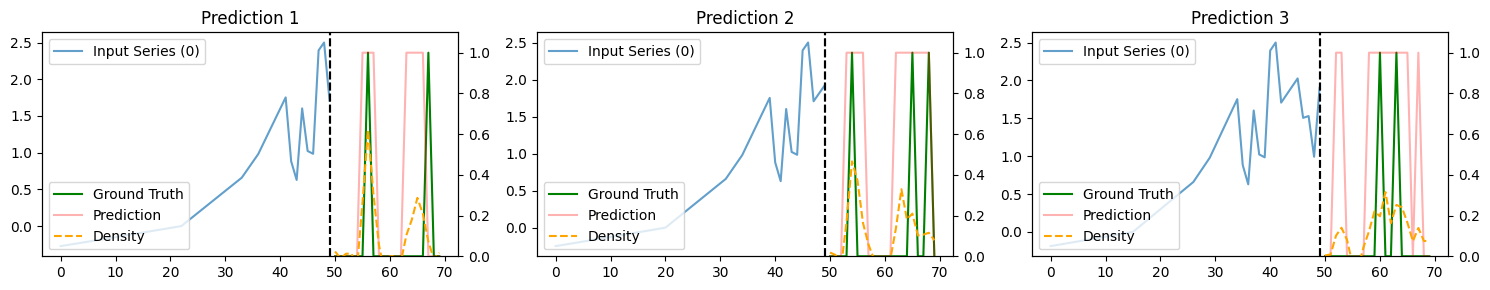

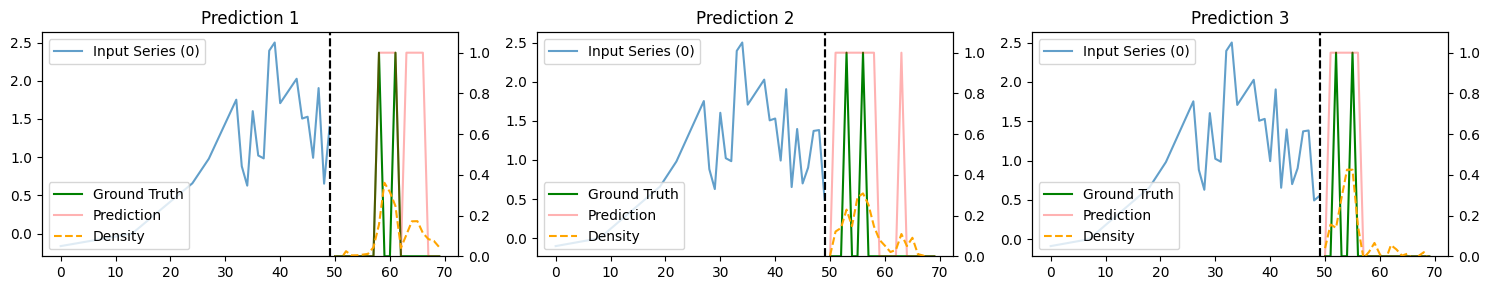

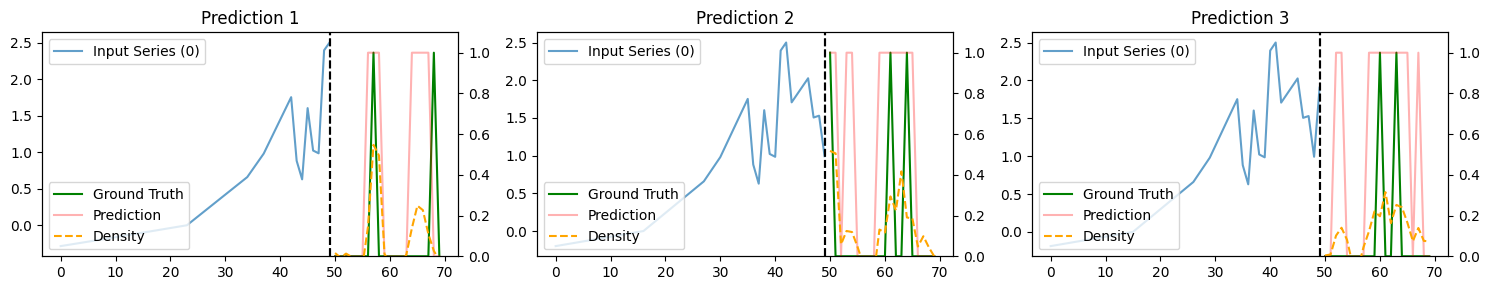

In [41]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_random_predictions(dataloader, model, num_predictions=3):
    """
    Plot randomly selected predictions and ground truth values from the dataloader.

    Parameters:
    - dataloader (DataLoader): The DataLoader to get data from.
    - model (nn.Module): The trained model used for making predictions.
    - num_predictions (int): The number of random predictions to plot (default is 3).
    """
    model.eval()
    sample_list = []
    for (inputs, labels) in dataloader:
        for i in range(len(inputs)):
            if labels[i].sum() > 1.0 and np.random.random() < 0.2:
                sample_list.append((inputs[i], labels[i]))
            if len(sample_list) > num_predictions:
                break

    fig, axes = plt.subplots(1, num_predictions, figsize=(5*num_predictions, num_predictions))

    activation_threshold = 0.1
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_list):
            if i >= num_predictions:
                break
            inputs = torch.unsqueeze(inputs.float(), 0)
            outputs = model(inputs).detach().cpu().numpy()
            inputs = inputs[0].detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            predictions = outputs > activation_threshold
            
            # Plot input series on the primary y-axis
            for k in range(inputs.shape[1]):
                axes[i].plot(inputs[:, k].flatten(), label=f'Input Series ({k})', alpha=0.7)
            
            # Create a secondary y-axis
            ax2 = axes[i].twinx()
            ax2.plot(np.arange(len(inputs[:, 0].flatten()), len(inputs[:, 0].flatten()) + len(labels.flatten())), labels.flatten(), label='Ground Truth', color='green')
            ax2.plot(np.arange(len(inputs[:, 0].flatten()), len(inputs[:, 0].flatten()) + len(predictions.flatten())), predictions.flatten(), label='Prediction', color='red', linestyle='-', alpha=0.3)
            ax2.plot(np.arange(len(inputs[:, 0].flatten()), len(inputs[:, 0].flatten()) + len(outputs.flatten())), outputs.flatten(), label='Density', color='orange', linestyle='dashed')
            
            # Set the y-axis limit of the secondary axis to [0, 1]
            ax2.set_ylim(0, 1.1)
            
            # Plot the vertical line on both axes
            axes[i].axvline(x=len(inputs[:, 0].flatten()) - 1, color='black', linestyle='--')
            ax2.axvline(x=len(inputs[:, 0].flatten()) - 1, color='black', linestyle='--')
            
            # Set legends and titles
            axes[i].legend(loc='upper left')
            ax2.legend(loc='lower left')
            axes[i].set_title(f'Prediction {i+1}')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `test_loader` is your DataLoader and `model` is your trained model.
plot_random_predictions(test_loader, model, num_predictions=3)
plot_random_predictions(test_loader, model, num_predictions=3)
plot_random_predictions(test_loader, model, num_predictions=3)


In [ ]:
# Prepare Dataset
input_length = 50
output_length = 20
result_dict = {}

for f_name in f_name_list[9:10]:
    with open(result_path  + "result_dnn.pkl", "rb") as f:
      result_dict = pkl.load(f)
    result_dict["DNN"] = result_dict.get("DNN", {})
    if f_name[-17:] in result_dict['DNN']:
      continue

    # Prepare Dataset
    with open(data_path + f_name.split("/")[-1], "rb") as f:
        X,y = pkl.load(f)
        num_features = X.shape[1]
        dataset = TimeSeriesDataset(X, y, input_length, output_length, device=device)

    # Define the model
    model = SimpleLinearModel(input_size=input_length * num_features, output_size=output_length).to(device)
    TP, TN, FP, FN, f1_existence, average_density_sum, average_lead_time, average_dice_score, average_cumloss_scores, train_loss_list, val_loss_list, test_loss_list, train_loader, val_loader, test_loader\
           = experiments(X, y , dataset, model)

    print(f'Results: {f_name[-17:]}')
    print(f'Existence of Anomaly - TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
    print(f'F1 Score (Existence of Anomaly): {f1_existence}')
    print(f'Average_density_sum: {average_density_sum}')
    print(f'Average Lead Time: {average_lead_time}')
    print(f'Average Dice Score: {average_dice_score}')
    print(f'Average cumloss: {average_cumloss_scores}')

    with open(result_path + "result_dnn.pkl", "rb") as f:
      result_dict = pkl.load(f)
    result_dict["DNN"] = result_dict.get("DNN", {})
    result_dict['DNN'].update({f_name[-17:]:[TP, TN, FP, FN, f1_existence, average_density_sum, average_lead_time, average_dice_score, average_cumloss_scores, train_loss_list, val_loss_list, test_loss_list]})
    with open(result_path  + "result_dnn.pkl", "wb") as f:
      pkl.dump(result_dict, f)
      

In [21]:
print(f'Mean F1 Score (Existence of Anomaly): {np.mean(f1_existence)}')
print(f'Mean Average Lead Time: {np.mean(average_lead_time)}')
print(f'Mean Average Dice Score: {np.mean(average_dice_score)}')
print(f'Mean Average cumloss: {np.mean(average_cumloss_scores)}')

Mean F1 Score (Existence of Anomaly): 0.6017699115044248
Mean Average Lead Time: 0.772216386554622
Mean Average Dice Score: 0.42272173190815726
Mean Average cumloss: 0.04700980963143694


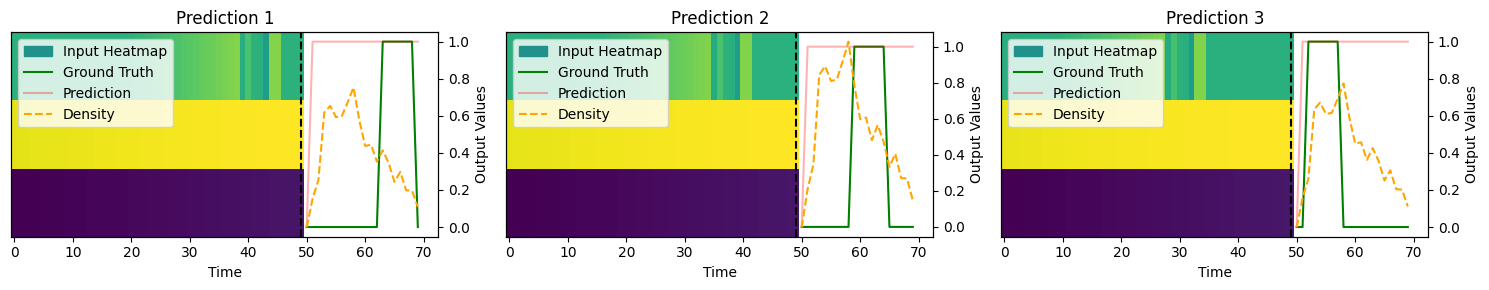

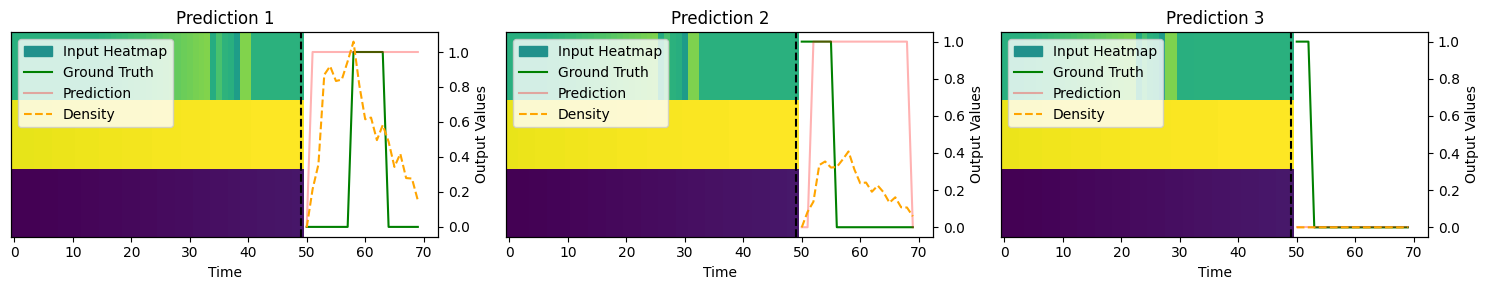

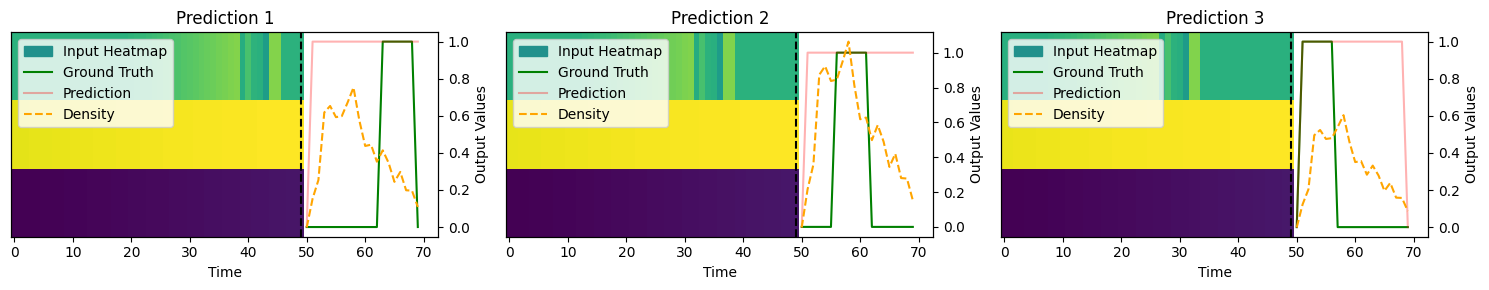

In [23]:
import matplotlib.pyplot as plt
import random
import numpy as np  # Ensure numpy is imported
import torch  # Ensure torch is imported
from matplotlib.patches import Patch  # Import Patch for custom legend entries

def plot_random_predictions(dataloader, model, num_predictions=3):
    """
    Plot randomly selected predictions and ground truth values from the dataloader.

    Parameters:
    - dataloader (DataLoader): The DataLoader to get data from.
    - model (nn.Module): The trained model used for making predictions.
    - num_predictions (int): The number of random predictions to plot (default is 3).
    """
    model.eval()
    sample_list = []
    for (inputs, labels) in dataloader:
        for i in range(len(inputs)):
            if labels[i].sum() > 1.0 and np.random.random() < 0.2:
                sample_list.append((inputs[i], labels[i]))
            if len(sample_list) > num_predictions:
                break

    fig, axes = plt.subplots(1, num_predictions, figsize=(5*num_predictions, num_predictions))

    # Ensure axes is iterable
    if num_predictions == 1:
        axes = [axes]

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_list):
            if i >= num_predictions:
                break
            inputs = torch.unsqueeze(inputs.float(), 0).to(device)
            outputs = model(inputs).detach().cpu().numpy()
            inputs = inputs[0].detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            predictions = outputs > 0.1

            # Plot the inputs as heatmaps
            im = axes[i].imshow(inputs.T, aspect='auto', origin='lower', interpolation='nearest', cmap='viridis')

            # Add colorbar
            # fig.colorbar(im, ax=axes[i])

            # Create a secondary y-axis for outputs
            ax2 = axes[i].twinx()

            # Adjust x-axis for labels and predictions
            input_length = inputs.shape[0]
            time_labels = np.arange(input_length, input_length + len(labels.flatten()))

            # Plot the outputs on the secondary y-axis
            ax2.plot(time_labels, labels.flatten(), label='Ground Truth', color='green')
            ax2.plot(time_labels, predictions.flatten(), label='Prediction', color='red', linestyle='-', alpha=0.3)
            ax2.plot(time_labels, outputs.flatten(), label='Density', color='orange', linestyle='dashed')

            # Plot the vertical line
            axes[i].axvline(x=input_length - 1, color='black', linestyle='--')

            # Hide the y-axis scale for the input (primary axis)
            axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
            axes[i].set_ylabel('')  # Remove y-axis label

            # Set y-axis label for the outputs (secondary axis)
            ax2.set_ylabel('Output Values')

            # Create custom legend entries
            handles1, labels1 = axes[i].get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()

            # Combine handles and labels
            handles = handles1 + handles2
            legend_labels = labels1 + labels2

            # Create a custom patch for the input heatmap
            cmap = plt.get_cmap('viridis')
            midpoint_color = cmap(0.5)
            input_patch = Patch(color=midpoint_color, label='Input Heatmap')

            # Insert the input_patch at the beginning of the handles and labels
            handles.insert(0, input_patch)
            legend_labels.insert(0, 'Input Heatmap')

            # Update the legend with the custom handles and labels
            axes[i].legend(handles=handles, labels=legend_labels, loc='upper left')

            axes[i].set_title(f'Prediction {i+1}')

            # Optionally, set the x-axis label
            axes[i].set_xlabel('Time')

        plt.tight_layout()
        plt.show()

# Example usage
# Ensure 'device' is defined, e.g.,
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assuming `test_dataloader` is your DataLoader and `model` is your trained model.
plot_random_predictions(test_loader, model, num_predictions=3)
plot_random_predictions(test_loader, model, num_predictions=3)
plot_random_predictions(test_loader, model, num_predictions=3)
